In [1]:
#https://simpletransformers.ai/docs/installation/
!pip install simpletransformers
!pip install datasets
!pip install torch

In [2]:
import os

BASE_DIR = os.getcwd()
TRAINED_BEST_MODEL_DIR = os.path.join(BASE_DIR, "outputs/best_model/")

MODEL_FILE = "pytorch_model.bin" 

In [3]:
#https://huggingface.co/docs/datasets/v1.11.0/loading_datasets.html
## download the dataset 
from datasets import load_dataset

## Squad is Q & A dataset
datasets = load_dataset("squad")

## Check the number of record/dataformat in train and validation
print(datasets["train"].shape , datasets["validation"].shape)

print(datasets["train"])
print(datasets["train"][0])


C:\Users\padma\anaconda3\envs\nlp\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


(87599, 5) (10570, 5)
Dataset({
    features: ['id', 'title', 'context', 'question', 'answers'],
    num_rows: 87599
})
{'id': '5733be284776f41900661182', 'title': 'University_of_Notre_Dame', 'context': 'Architecturally, the school has a Catholic character. Atop the Main Building\'s gold dome is a golden statue of the Virgin Mary. Immediately in front of the Main Building and facing it, is a copper statue of Christ with arms upraised with the legend "Venite Ad Me Omnes". Next to the Main Building is the Basilica of the Sacred Heart. Immediately behind the basilica is the Grotto, a Marian place of prayer and reflection. It is a replica of the grotto at Lourdes, France where the Virgin Mary reputedly appeared to Saint Bernadette Soubirous in 1858. At the end of the main drive (and in a direct line that connects through 3 statues and the Gold Dome), is a simple, modern stone statue of Mary.', 'question': 'To whom did the Virgin Mary allegedly appear in 1858 in Lourdes France?', 'answers':

## Process and reformat the Train and test dataset to pass to SimpleTransformer

https://www.kaggle.com/code/ejaz22/question-answering-using-simpletransformer/notebook

sample 1   
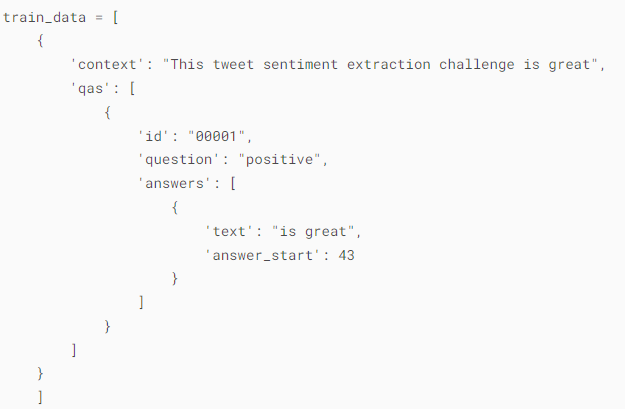

sample 2    
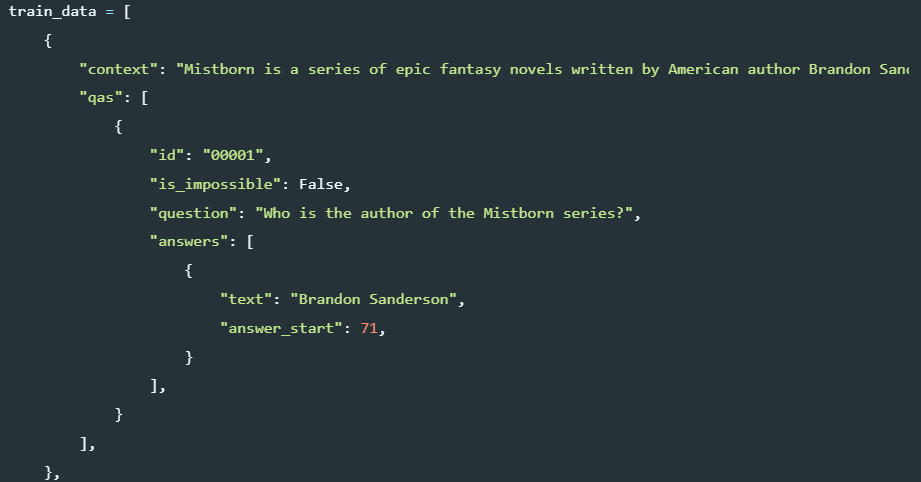

In [4]:
 ### Format source :: https://simpletransformers.ai/docs/qa-minimal-start/

def prepare_data_format(data):
    formatted_data = []

    for i in range(len(data)):
        current_row = data[i]
        formatted_dict = {}
        formatted_dict['context'] = current_row.get('context')

        qas = []
        quest_dict = {}
        quest_dict['id'] = current_row.get('id')
        quest_dict['question'] = current_row.get('question')

        answers = []
        org_answer = current_row.get('answers')

        if len(org_answer['text']) > 0:
            quest_dict['is_impossible'] = False
        else:
            quest_dict['is_impossible'] = True

        for j in range(len(org_answer['text'])):
            answers_dict = {}
            answers_dict['text'] = org_answer['text'][j]
            answers_dict['answer_start'] = org_answer['answer_start'][j]
            answers.append(answers_dict)

        quest_dict['answers'] = answers
        qas.append(quest_dict)

        formatted_dict['qas'] = qas
        formatted_data.append(formatted_dict)

    return formatted_data

# Process all items in the train and validation datasets
train_data = prepare_data_format(datasets["train"])
test_data = prepare_data_format(datasets["validation"])

train_data[0]

{'context': 'Architecturally, the school has a Catholic character. Atop the Main Building\'s gold dome is a golden statue of the Virgin Mary. Immediately in front of the Main Building and facing it, is a copper statue of Christ with arms upraised with the legend "Venite Ad Me Omnes". Next to the Main Building is the Basilica of the Sacred Heart. Immediately behind the basilica is the Grotto, a Marian place of prayer and reflection. It is a replica of the grotto at Lourdes, France where the Virgin Mary reputedly appeared to Saint Bernadette Soubirous in 1858. At the end of the main drive (and in a direct line that connects through 3 statues and the Gold Dome), is a simple, modern stone statue of Mary.',
 'qas': [{'id': '5733be284776f41900661182',
   'question': 'To whom did the Virgin Mary allegedly appear in 1858 in Lourdes France?',
   'is_impossible': False,
   'answers': [{'text': 'Saint Bernadette Soubirous', 'answer_start': 515}]}]}

In [5]:
print(len(train_data), len(test_data))

#We take only 5000 rows to reduce training time
train_data  = train_data[:5000]
validation_data = test_data[:1000]
test_data = test_data[1000:2000]

87599 10570


## Fine-Tuning a Pretrained Question-Answering Model with SimpleTransformers


In [14]:
#https://simpletransformers.ai/docs/qa-minimal-start/
import logging

from simpletransformers.question_answering import QuestionAnsweringModel, QuestionAnsweringArgs

logging.basicConfig(level=logging.WARNING)
transformers_logger = logging.getLogger("transformers")
transformers_logger.setLevel(logging.WARNING)

def get_model_name(model_type):
    if model_type == "bert":
        model_name = "bert-base-cased"
    
    elif model_type == "roberta":
        model_name = "roberta-base"
    
    elif model_type == "distilbert":
        model_name = "distilbert-base-uncased-distilled-squad"
    
    elif model_type == "distilroberta":
        model_type = "roberta"
        model_name = "distilroberta-base"
    
    elif model_type == "electra-base":
        model_type = "electra"
        model_name = "google/electra-base-discriminator"
    
    elif model_type == "electra-small":
        model_type = "electra"
        model_name = "google/electra-small-discriminator"
    
    elif model_type == "xlnet":
        model_name = "xlnet-base-cased"

    return model_name
    

### https://www.kaggle.com/code/ejaz22/question-answering-using-simpletransformer/notebook
## https://simpletransformers.ai/docs/usage/
def train_qa_model(model_type):
    model_name = get_model_name(model_type)
    
    train_args = {'reprocess_input_data': True,
                  'overwrite_output_dir': True,
                  'learning_rate': 5e-5,
                  'num_train_epochs': 2,
    
                  ## For early stop
                  'evaluate_during_training': True,
                  "use_early_stopping": True,
                  "early_stopping_metric": "eval_loss",
                  #"early_stopping_patience": 3,
                  'weight_decay' : 0.01,
    
                  ## Specify the max context length
                  'max_seq_length': 512,
                  ## The authorized overlap between two part of the context when splitting
                  'doc_stride': 128,
                  'fp16': False
                  }
    
    # Create the QuestionAnsweringModel
    model = QuestionAnsweringModel(model_type,model_name, 
                                   args=train_args,
                                  use_cuda=False)
    
    model.train_model(train_data, eval_data=validation_data)

    return model

### Initiate the Fine-Tuning Process


In [15]:
model_type="distilbert" 
model_name = get_model_name(model_type)

model = train_qa_model(model_type)

Epochs 0/2. Running Loss:    1.0859:   4%|██▋                                                          | 27/626 [02:15<49:08,  4.92s/it]


Epochs 0/2. Running Loss:    1.8234:   9%|█████▍                                                       | 56/626 [04:59<57:43,  6.08s/it]


Epochs 0/2. Running Loss:    1.4918:  14%|████████▎                                                    | 85/626 [07:41<49:21,  5.47s/it]


Epochs 0/2. Running Loss:    1.8708:  18%|██████████▉                                                 | 114/626 [10:22<47:27,  5.56s/it]


Epochs 0/2. Running Loss:    1.7838:  23%|█████████████▋                                              | 143/626 [13:05<46:05,  5.73s/it]


Epochs 0/2. Running Loss:    1.1586:  27%|████████████████▍                                           | 172/626 [15:36<35:50,  4.74s/it]


Epochs 0/2. Running Loss:    1.1112:  32%|███████████████████▎                                        | 201/626 [17:53<33:43,  4.76s/it]


Epochs 0/2. Running Loss:    0.6096:  37%|██████████████████████                                      | 230/626 [20:10<31:04,  4.71s/it]


Epochs 0/2. Running Loss:    1.1629:  41%|████████████████████████▊                                   | 259/626 [22:30<30:05,  4.92s/it]


Epochs 0/2. Running Loss:    0.9040:  46%|███████████████████████████▌                                | 288/626 [24:50<26:46,  4.75s/it]


Epochs 0/2. Running Loss:    0.9873:  51%|██████████████████████████████▍                             | 317/626 [27:08<24:27,  4.75s/it]


Epochs 0/2. Running Loss:    0.9578:  55%|█████████████████████████████████▏                          | 346/626 [29:28<23:02,  4.94s/it]


Epochs 0/2. Running Loss:    1.4697:  60%|███████████████████████████████████▉                        | 375/626 [31:50<21:12,  5.07s/it]


Epochs 0/2. Running Loss:    2.1292:  65%|██████████████████████████████████████▋                     | 404/626 [34:08<17:44,  4.79s/it]


Epochs 0/2. Running Loss:    1.1686:  69%|█████████████████████████████████████████▌                  | 433/626 [36:26<15:15,  4.75s/it]


Epochs 0/2. Running Loss:    1.2387:  74%|████████████████████████████████████████████▎               | 462/626 [38:45<13:13,  4.84s/it]


Epochs 0/2. Running Loss:    1.2148:  78%|███████████████████████████████████████████████             | 491/626 [41:06<10:48,  4.80s/it]


Epochs 0/2. Running Loss:    0.7574:  83%|█████████████████████████████████████████████████▊          | 520/626 [43:26<08:37,  4.88s/it]


Epochs 0/2. Running Loss:    0.8596:  88%|████████████████████████████████████████████████████▌       | 549/626 [45:46<06:16,  4.89s/it]


Epochs 0/2. Running Loss:    1.0377:  92%|███████████████████████████████████████████████████████▍    | 578/626 [48:04<03:50,  4.80s/it]


Epochs 0/2. Running Loss:    1.2680:  97%|██████████████████████████████████████████████████████████▏ | 607/626 [50:23<01:30,  4.76s/it]


Epochs 0/2. Running Loss:    1.7499: 100%|████████████████████████████████████████████████████████████| 626/626 [51:54<00:00,  4.97s/it]

convert squad examples to features: 100%|██████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 410.81it/s]

add example index and unique id: 100%|█████████████████████████████████████████████████████████| 1000/1000 [00:00<00:00, 1038194.06it/s]

Running Evaluation:  12%|█████████▎                                                                    | 15/125 [00:29<03:43,  2.03s/it]


Running Evaluation:  58%|█████████████████████████████████████████████▌                                | 73/125 [02:21<01:41,  1.95s/it]


Epochs 1/2. Running Loss:    0.9405:   0%|▏                                                             | 2/626 [00:09<49:43,  4.78s/it]


Epochs 1/2. Running Loss:    0.4061:   5%|███                                                          | 31/626 [02:27<46:29,  4.69s/it]


Epochs 1/2. Running Loss:    0.1436:  10%|█████▊                                                       | 60/626 [04:56<48:58,  5.19s/it]


Epochs 1/2. Running Loss:    0.4923:  14%|████████▋                                                    | 89/626 [07:15<43:32,  4.87s/it]


Epochs 1/2. Running Loss:    0.5656:  19%|███████████▎                                                | 118/626 [09:44<46:34,  5.50s/it]


Epochs 1/2. Running Loss:    0.3369:  23%|██████████████                                              | 147/626 [12:22<39:09,  4.90s/it]


Epochs 1/2. Running Loss:    0.9076:  28%|████████████████▊                                           | 176/626 [14:40<35:11,  4.69s/it]


Epochs 1/2. Running Loss:    1.0998:  33%|███████████████████▋                                        | 205/626 [16:57<33:18,  4.75s/it]


Epochs 1/2. Running Loss:    0.2480:  37%|██████████████████████▍                                     | 234/626 [19:15<30:40,  4.70s/it]


Epochs 1/2. Running Loss:    0.4343:  42%|█████████████████████████▏                                  | 263/626 [21:31<28:29,  4.71s/it]


Epochs 1/2. Running Loss:    0.4219:  47%|███████████████████████████▉                                | 292/626 [23:48<26:21,  4.73s/it]


Epochs 1/2. Running Loss:    1.1213:  51%|██████████████████████████████▊                             | 321/626 [26:11<24:07,  4.75s/it]


Epochs 1/2. Running Loss:    2.3579:  56%|█████████████████████████████████▌                          | 350/626 [28:27<21:14,  4.62s/it]


Epochs 1/2. Running Loss:    0.2572:  61%|████████████████████████████████████▎                       | 379/626 [30:46<20:48,  5.06s/it]


Epochs 1/2. Running Loss:    1.1433:  65%|███████████████████████████████████████                     | 408/626 [33:14<18:41,  5.14s/it]


Epochs 1/2. Running Loss:    0.6743:  70%|█████████████████████████████████████████▉                  | 437/626 [35:42<16:00,  5.08s/it]


Epochs 1/2. Running Loss:    0.8965:  74%|████████████████████████████████████████████▋               | 466/626 [38:09<13:31,  5.07s/it]


Epochs 1/2. Running Loss:    0.4730:  79%|███████████████████████████████████████████████▍            | 495/626 [40:47<12:40,  5.80s/it]


Epochs 1/2. Running Loss:    0.7848:  84%|██████████████████████████████████████████████████▏         | 524/626 [43:29<09:42,  5.71s/it]


Epochs 1/2. Running Loss:    0.7269:  88%|█████████████████████████████████████████████████████       | 553/626 [46:06<06:24,  5.26s/it]


Epochs 1/2. Running Loss:    0.5437:  93%|███████████████████████████████████████████████████████▊    | 582/626 [48:38<03:40,  5.01s/it]


Epochs 1/2. Running Loss:    0.7347:  98%|██████████████████████████████████████████████████████████▌ | 611/626 [51:09<01:18,  5.25s/it]


Epochs 1/2. Running Loss:    0.3483: 100%|████████████████████████████████████████████████████████████| 626/626 [52:31<00:00,  5.03s/it]

convert squad examples to features: 100%|██████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 415.59it/s]

add example index and unique id: 100%|█████████████████████████████████████████████████████████| 1000/1000 [00:00<00:00, 1003422.01it/s]

Running Evaluation:  18%|██████████████▎                                                               | 23/125 [00:49<04:13,  2.48s/it]


Running Evaluation:  65%|██████████████████████████████████████████████████▌                           | 81/125 [02:55<01:34,  2.15s/it]


Epoch 2 of 2: 100%|███████████████████████████████████████████████████████████████████████████████████| 2/2 [1:54:31<00:00, 3435.88s/it]


#### Important Training Notes

## Evaluating the Fine-Tuned Model

In [16]:
# Evaluate the model
test_result, texts = model.eval_model(test_data)

Running Evaluation: 100%|█████████████████████████████████████████████████████████████████████████████| 125/125 [04:16<00:00,  2.05s/it]


In [17]:
def get_result_stats(result):
    # Calculate the total number of examples
    total_examples = result['correct'] + result['similar'] + result['incorrect']

    # Calculate the percentage of correct and incorrect answers
    percentage_correct = (result['correct'] / total_examples) * 100
    percentage_similar = (result['similar'] / total_examples) * 100
    percentage_incorrect = (result['incorrect'] / total_examples) * 100

    # Print the results
    print(f"Percentage Correct: {percentage_correct:.2f}%")
    print(f"Percentage Similar: {percentage_similar:.2f}%")
    print(f"Percentage Incorrect: {percentage_incorrect:.2f}%")
    
    
get_result_stats(test_result)

Percentage Correct: 39.10%
Percentage Similar: 37.10%
Percentage Incorrect: 23.80%


## Loading a Trained Question-Answering Model

In [18]:
model1 = QuestionAnsweringModel(model_type, model_name, "outputs/best_model/pytorch_model.bin",use_cuda=False)

In [19]:
to_predict  = [
    {
        'context': "This tweet sentiment extraction challenge is great",
        'qas': [
            {
                'id': "00001",
                'question': "how is the extraction challenge?"
            }
        ]
    }
    ]
answers, probabilities = model1.predict(to_predict)
print(probabilities)
print(answers)

print()
print(answers[0]['answer'][0])

Running Prediction: 100%|█████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 15.45it/s]

[{'id': '00001', 'probability': [0.4764501442512536, 0.22133093083046212, 0.08420875663697376, 0.0672294325106596, 0.042693106542047145, 0.0401667007520493, 0.018659104993683298, 0.015729232256855397, 0.009181423400293133, 0.007099143466217075, 0.0056677168219341, 0.0027800161405880162, 0.0025996052490577124, 0.0022194711686331237, 0.0015930192195132843, 0.0007740316392956299, 0.0006926254846777607, 0.00031432424864093585, 0.0003075982555643671, 0.0003031098696353427]}]
[{'id': '00001', 'answer': ['tweet sentiment extraction challenge is great', 'tweet', 'tweet sentiment', 'tweet sentiment extraction challenge', 'great', 'This tweet sentiment extraction challenge is great', 'This tweet', 'sentiment extraction challenge is great', 'tweet sentiment extraction', 'This tweet sentiment', 'This tweet sentiment extraction challenge', 'sentiment', 'is great', 'sentiment extraction challenge', 'twee', 'This tweet sentiment extraction', 'extraction challenge is great', 't sentiment extraction ch

In [20]:
# Make predictions with the model
to_predict = [
    {
        "context": """Keras is an API designed for human beings, not machines. Keras follows best
        practices for reducing cognitive load: it offers consistent & simple APIs, it minimizes
        the number of user actions required for common use cases, and it provides clear &
        actionable error messages. It also has extensive documentation and developer guides. """,
        "qas": [
            {
                "question": "what is keras?",
                "id": "0",
            }
        ],
    }
]

answers, probabilities = model1.predict(to_predict)

print(answers[0])
#print(answers[0]['answer'][0])
print(probabilities[0])

print()

print(answers[0]['answer'][0])

Running Prediction: 100%|█████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 14.67it/s]

{'id': '0', 'answer': ['an API designed for human beings, not machines.', 'designed for human beings, not machines', 'human beings, not machines', 'an API designed for human beings,', 'for human beings, not machines', 'designed for human beings', 'designed for human beings, not machines.', 'human beings', 'API designed for human beings, not machines.', 'human beings, not machines.', 'not machines', 'for human beings', 'for human beings, not machines.', 'machines', 'an API', 'Keras is an API designed for human beings, not machines.', 'API designed for human beings,', 'an API designed', 'not machines.', 'is an API designed for human beings, not machines.']}
{'id': '0', 'probability': [0.4610065041811648, 0.21146903058882746, 0.12586994792535774, 0.05138131466794129, 0.044769294884010914, 0.02356920499963084, 0.019409069780933246, 0.014028789925811259, 0.011936491494953082, 0.0115526069978342, 0.005888940418315522, 0.004989745712987279, 0.004109019491068939, 0.003113576354901904, 0.002108

In [21]:
question_data = {
  'qas': 
  [{'question': 'What color is the tree?',
    'id': 0,
    'answers': [{'text': ' ', 'answer_start': 0}],
    'is_impossible': False}],
  'context': 'This is an old tree. It is green and tall. '
  }

prediction = model1.predict([question_data])
print(prediction)
answers, probabilities = prediction
print()
print("Predicted Answer")
print(answers[0]['answer'][0])

Running Prediction: 100%|█████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.87it/s]

([{'id': 0, 'answer': ['green', 'green and tall', 'green and tall.', 'It is green', 'old tree. It is green', 'It is green and tall.', 'an old tree. It is green', 'This is an old tree. It is green', 'old tree. It is green and tall.', 'tree. It is green', 'is green', 'an old tree. It is green and tall.', 'tall', 'This is an old tree. It is green and tall.', 'tall.', 'tree. It is green and tall.', 'It', 'is green and tall', 'green and', 'is an old tree. It is green']}], [{'id': 0, 'probability': [0.8537048171428372, 0.10549178581085955, 0.025128506899001632, 0.00985710003377123, 0.0016600747272080701, 0.0012180358650885183, 0.0011707990322970645, 0.0007521553801507849, 0.0002051344258999935, 0.0001770689462051356, 0.00015793990516324162, 0.0001446749254104052, 0.00011837506149761132, 9.294338355136219e-05, 2.8197347562640826e-05, 2.1880302150973404e-05, 2.171423425632025e-05, 1.9516538166236524e-05, 1.8692899396748453e-05, 1.0583387911830048e-05]}])

Predicted Answer
green
